## BlackSheep Cookbook Exploration

The Black Sheep Analysis allows researchers to find trends in abnormal protein enrichment among patients in CPTAC datasets. In this Cookbook, we will go through the steps needed to perform a full Black Sheep Analysis.

### Step 1a: Import Dependencies
First, import the necessary dependencies and load cptac data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cptac
import binarization_functions as bf
import blackSheepCPTACmoduleCopy as blsh
import gseapy as gp
from gseapy.plot import barplot, heatmap, dotplot

Welcome to cptac, a python package for disseminating cancer
proteogenomics data. To view available datasets, enter
'cptac.list_data()'. Extensive tutorials are available at
https://github.com/PayneLab/cptac/tree/master/doc

******
Version: 0.4.5
******
Checking that data files are up-to-date...
100% [..................................................................................] 649 / 649
Data check complete.
endometrial data version: 2.1

Loading acetylproteomics data...
Loading clinical data...
Loading CNA data...
Loading definitions data...
Loading miRNA data...
Loading phosphoproteomics_gene data...
Loading phosphoproteomics_site data...
Loading proteomics data...
Loading somatic data...
Loading somatic_binary data...
Loading transcriptomics_circular data...
Loading transcriptomics_linear data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utiliz

## Step 1b: Load Data and Choose Omics Table
For this analysis, we will be looking at results across the proteomics, transcriptomics, and phosphoproteomics tables.

In [45]:
en = cptac.Endometrial()
proteomics = en.get_proteomics()
transcriptomics = en.get_transcriptomics()
clinical = en.get_clinical()

Checking that data files are up-to-date...
100% [..................................................................................] 649 / 649
Data check complete.
endometrial data version: 2.1

Loading acetylproteomics data...
Loading clinical data...
Loading CNA data...
Loading definitions data...
Loading miRNA data...
Loading phosphoproteomics_gene data...
Loading phosphoproteomics_site data...
Loading proteomics data...
Loading somatic data...
Loading somatic_binary data...
Loading transcriptomics_circular data...
Loading transcriptomics_linear data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but analysis may not be
published until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter cptac.embargo() to open the webpage for more details.


In [3]:
#Append Genomics_subtype and MSI_status to clinical table
df= en.get_derived_molecular()
clinical['MSI_status'] = df['MSI_status']
clinical['Genomics_subtype'] = df['Genomics_subtype']

## Step 2: Determine what attributes you would like to A/B test. 
For this analysis, we will iteratively go through the various columns in the clinical dataset, to determine if any of them have trends within them for protein enrichment.

In [4]:
#Create a copy of the original Clinical DataFrame and drop irrelevant columns.
annotations = pd.DataFrame(clinical.copy())
annotations = annotations.drop(['Patient_ID', 
                                'Treatment_naive', 
                                'Tumor_purity', 
                                'Gender', 
                                'Tumor_Site_Other'], axis=1)

## Step 2a: Binarize column values

In [5]:
tumor_map = {'Tumor':'Normal_Tumor', 
             'Adjacent_normal':'Other_tumor', 
             'Enriched_normal':'Other_tumor', 
             'Myometrium_normal':'Other_tumor'}

annotations['Proteomics_Tumor_Normal'] = bf.binarizeCategorical(clinical, 
                                                                'Proteomics_Tumor_Normal', 
                                                                tumor_map)

In [6]:
country_map = {'United States':'US', 
               'Ukraine':'Other', 
               'Other_specify':'Other', 
               'Poland':'Other'}

annotations['Country'] = bf.binarizeCategorical(clinical, 
                                                'Country', 
                                                country_map)

In [7]:
annotations['BMI'] = bf.binarizeRange(clinical, 'BMI', 18, 25, 
                                      'Healthy', 'Unhealthy')

annotations['Age'] = bf.binarizeCutOff(clinical, 'Age', 
                                       60.0, 'Old', 'Young')

In [8]:
FIGO_map = {'FIGO grade 1':'Low_grade', 
            'FIGO grade 2':'High_grade', 
            'FIGO grade 3':'High_grade'}

annotations['Histologic_Grade_FIGO'] = bf.binarizeCategorical(clinical, 
                                                              'Histologic_Grade_FIGO', 
                                                              FIGO_map)

In [9]:
Myo_map = {'under 50 %':'under_50%', 
           '50 % or more': '50%_or_more', 
           'Not identified': 'under_50%'}

annotations['Myometrial_invasion_Specify'] = bf.binarizeCategorical(clinical, 
                                                                    'Myometrial_invasion_Specify', 
                                                                    Myo_map)

In [10]:
path_tumor_map = {'pT1a (FIGO IA)':'Not_FIGO_III', 
            'pT1b (FIGO IB)':'Not_FIGO_III', 
            'pT2 (FIGO II)':'Not_FIGO_III', 
            'pT1 (FIGO I)':'Not_FIGO_III', 
            'pT3a (FIGO IIIA)':'FIGO_III', 
            'pT3b (FIGO IIIB)':'FIGO_III'}

annotations['Path_Stage_Primary_Tumor-pT'] = bf.binarizeCategorical(clinical, 
                                                                    'Path_Stage_Primary_Tumor-pT', 
                                                                    path_tumor_map)

In [11]:
path_lymph_map = {'pN0':'Not_FIGO_III', 
                  'pNX':'Not_FIGO_III', 
                  'pN1 (FIGO IIIC1)':'FIGO_III', 
                  'pN2 (FIGO IIIC2)':'FIGO_III'}

annotations['Path_Stage_Reg_Lymph_Nodes-pN'] = bf.binarizeCategorical(clinical, 
                                                                      'Path_Stage_Reg_Lymph_Nodes-pN', 
                                                                      path_lymph_map)

In [12]:
clin_stage_map = {'cM0':'cM0_or_cM1', 
                  'cM1':'cM0_or_cM1', 
                  'Staging Incomplete':'Staging_Incomplete'}

annotations['Clin_Stage_Dist_Mets-cM'] = bf.binarizeCategorical(clinical, 
                                                                'Clin_Stage_Dist_Mets-cM', 
                                                                clin_stage_map)

In [13]:
path_stage_map = {'Staging Incomplete': 'No_distant_metastasis', 
                  'No pathologic evidence of distant metastasis':'No_distant_metastasis', 
                  'pM1':'Distant_Metastasis'}

annotations['Path_Stage_Dist_Mets-pM'] = bf.binarizeCategorical(clinical, 
                                                                'Path_Stage_Dist_Mets-pM', 
                                                                path_stage_map)

In [14]:
tumor_stage_map = {'Stage I':'Stage_I_or_II', 
                   'Stage II':'Stage_I_or_II', 
                   'Stage III':'Stage_III_or_IV', 
                   'Stage IV':'Stage_III_or_IV'}

annotations['tumor_Stage-Pathological'] = bf.binarizeCategorical(clinical, 
                                                               'tumor_Stage-Pathological', 
                                                               tumor_stage_map)

In [15]:
FIGO_stage_map = {'IA':'I_or_II', 
                  'IB':'I_or_II', 
                  'II':'I_or_II', 
                  'IIIA':'III_or_IV', 
                  'IIIC1':'III_or_IV', 
                  'IVB':'III_or_IV', 
                  'IIIC2':'III_or_IV', 
                  'IIIB':'III_or_IV'}

annotations['FIGO_stage'] = bf.binarizeCategorical(clinical, 
                                                   'FIGO_stage', 
                                                   FIGO_stage_map)

In [16]:
diabetes_map = {'No':'No', 
                'Yes':'Yes', 
                'Unknown':'No'}

annotations['Diabetes'] = bf.binarizeCategorical(clinical, 
                                                 'Diabetes', 
                                                 diabetes_map)

In [17]:
race_map = {'White':'White', 
            'Black or African American':'Not_White', 
            'Asian':'Not_White', 
            'Not Reported':'Not_White'}

annotations['Race'] = bf.binarizeCategorical(clinical, 
                                             'Race', 
                                             race_map)

In [18]:
ethnicity_map = {'Not-Hispanic or Latino':'Not_Hispanic', 
                 'Not reported':'Not_Hispanic', 
                 'Hispanic or Latino':'Hispanic'}

annotations['Ethnicity'] = bf.binarizeCategorical(clinical, 
                                                  'Ethnicity', 
                                                  ethnicity_map)

In [19]:
tumor_site_map = {'Other, specify':'Not_Anterior', 
                  'Anterior endometrium':'Anterior', 
                  'Posterior endometrium':'Not_Anterior'}

annotations['Tumor_Site'] = bf.binarizeCategorical(clinical, 
                                                   'Tumor_Site', 
                                                   tumor_site_map)

In [20]:
annotations['Tumor_Size_cm'] = bf.binarizeCutOff(clinical, 
                                                'Tumor_Size_cm', 4.0, 
                                                'Large_tumor', 
                                                'Small_tumor')

In [21]:
num_pregnancies_map = {2:'Less_than_3', 
                       1:'Less_than_3', 
                       'None':'Less_than_3', 
                       None:'Less_than_3', 
                       3:'3_or_more', 
                       '4 or more':'3_or_more'}

annotations['Num_full_term_pregnancies'] = bf.binarizeCategorical(clinical, 
                                                                  'Num_full_term_pregnancies', 
                                                                  num_pregnancies_map)

In [22]:
genomics_map = {'MSI-H':'MSI-H', 
                'CNV_low':'Other_subtype', 
                'CNV_high':'Other_subtype', 
                'POLE':'Other_subtype'}

annotations['Genomics_subtype'] = bf.binarizeCategorical(clinical, 
                                                         'Genomics_subtype', 
                                                         genomics_map)

## Step 3: Perform outliers analysis

In [36]:
outliers_prot = blsh.make_outliers_table(proteomics, iqrs=1.5, 
                                         up_or_down='up', 
                                         aggregate=False, 
                                         frac_table=False)

outliers_trans = blsh.make_outliers_table(transcriptomics, iqrs=1.5, 
                                          up_or_down='up', 
                                          aggregate=False, 
                                          frac_table=False)

C:\Users\Daniel\AppData\Local\conda\conda\envs\Research\lib\site-packages\numpy\lib\nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


## Step 4: Wrap your A/B test into the outliers analysis, and create a table
First for proteomics, and then phosphoproteomics.

In [ ]:
results_prot = blsh.compare_groups_outliers(outliers_prot, 
                                            annotations)

In [43]:
results_trans = blsh.compare_groups_outliers(outliers_trans, 
                                             annotations)

KeyError: "['S130_outliers', 'S115_outliers', 'S109_outliers', 'S141_outliers', 'S132_outliers', 'S153_outliers', 'S140_outliers', 'S110_outliers', 'S113_outliers', 'S136_outliers', 'S118_outliers', 'S147_outliers', 'S145_outliers', 'S133_outliers', 'S137_outliers', 'S116_outliers', 'S117_outliers', 'S148_outliers', 'S143_outliers', 'S134_outliers', 'S146_outliers', 'S131_outliers', 'S139_outliers', 'S114_outliers', 'S152_outliers', 'S149_outliers', 'S112_outliers', 'S150_outliers', 'S135_outliers', 'S142_outliers', 'S138_outliers', 'S126_outliers', 'S151_outliers', 'S144_outliers', 'S123_outliers'] not in index"

Many of the output values from compare_group_outliers are NaN, so here we will get rid of the NaN values for visualization purposes.

In [ ]:
results_prot = results_prot.dropna(axis=0, how='all')
results_trans = results_trans.dropna(axis=0, how='all')

## Step 5: Visualize these enrichments

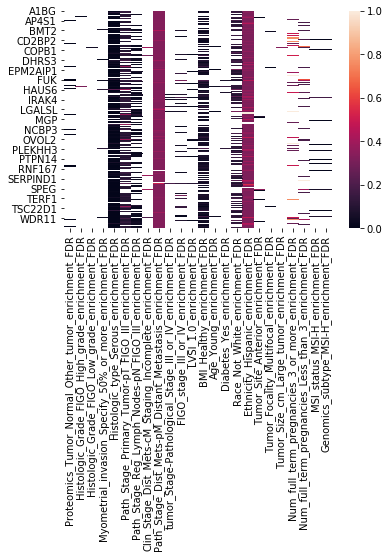

In [41]:
sns.heatmap(results_prot)
plt.show()

In [42]:
sns.heatmap(results_trans)
plt.show()

NameError: name 'results_trans' is not defined

In [27]:
#How can we automate something like this?
results_prot = results_prot.drop(['Proteomics_Tumor_Normal_Other_tumor_enrichment_FDR', 
                                  'Histologic_Grade_FIGO_High_grade_enrichment_FDR',
                                  'Histologic_Grade_FIGO_Low_grade_enrichment_FDR', 
                                  'Myometrial_invasion_Specify_50%_or_more_enrichment_FDR'], 
                                 axis=1)

## Step 6: Determine significant enrichments, and link with cancer drug database.

In [28]:
print("TESTING FOR PROTEOMICS:")
sig_cols = []
for col in results_prot.columns:
    sig_col = bf.significantEnrichments(results_prot, col, 0.025)
    if sig_col is not None:
        sig_cols.append(sig_col)
    else:
        continue

TESTING FOR PROTEOMICS:
538 significant protein enrichments in Histologic_type_Serous

26 significant protein enrichments in Path_Stage_Reg_Lymph_Nodes-pN_FIGO_III

4 significant protein enrichments in FIGO_stage_III_or_IV

9 significant protein enrichments in LVSI_1.0

7 significant protein enrichments in BMI_Healthy

3 significant protein enrichments in Age_Young

5 significant protein enrichments in Tumor_Site_Anterior

2 significant protein enrichments in Tumor_Focality_Multifocal

7 significant protein enrichments in MSI_status_MSI-H

7 significant protein enrichments in Genomics_subtype_MSI-H



In [32]:
for col in sig_cols:
    col_name = col.columns[0]
    gene_name_list = list(col.index)
    enrichment = gp.enrichr(gene_list = gene_name_list, 
                            description=col_name, 
                            gene_sets='KEGG_2019_Human', 
                            outdir='test/enrichr_kegg', #This isn't saving correctly...why is that?
                            cutoff=0.5)
    print(enrichment.res2d)
    barplot(enrichment.res2d, title=col_name)

            Gene_set                                               Term  \
0    KEGG_2019_Human            Glyoxylate and dicarboxylate metabolism   
1    KEGG_2019_Human                  Ribosome biogenesis in eukaryotes   
2    KEGG_2019_Human           Glycine, serine and threonine metabolism   
3    KEGG_2019_Human                          mRNA surveillance pathway   
4    KEGG_2019_Human                        Basal transcription factors   
5    KEGG_2019_Human                      Cytosolic DNA-sensing pathway   
6    KEGG_2019_Human                                     RNA polymerase   
7    KEGG_2019_Human                Amyotrophic lateral sclerosis (ALS)   
8    KEGG_2019_Human                                        Spliceosome   
9    KEGG_2019_Human                  Thyroid hormone signaling pathway   
10   KEGG_2019_Human                                 Lysine degradation   
11   KEGG_2019_Human                                 Endometrial cancer   
12   KEGG_2019_Human     

[192 rows x 10 columns]
           Gene_set                                               Term  \
0   KEGG_2019_Human                            African trypanosomiasis   
1   KEGG_2019_Human                 Cysteine and methionine metabolism   
2   KEGG_2019_Human                              TNF signaling pathway   
3   KEGG_2019_Human                       NF-kappa B signaling pathway   
4   KEGG_2019_Human                                        Spliceosome   
5   KEGG_2019_Human                                            Malaria   
6   KEGG_2019_Human                      Inositol phosphate metabolism   
7   KEGG_2019_Human              Phosphatidylinositol signaling system   
8   KEGG_2019_Human             Fluid shear stress and atherosclerosis   
9   KEGG_2019_Human  AGE-RAGE signaling pathway in diabetic complic...   
10  KEGG_2019_Human                     Cell adhesion molecules (CAMs)   
11  KEGG_2019_Human               Leukocyte transendothelial migration   
12  KEGG_2019_

3     0.009198              0.010725 -12.009321       61.977171  SRP19  
          Gene_set           Term Overlap   P-value  Adjusted P-value  \
0  KEGG_2019_Human        Measles   1/138  0.013753          0.016432   
1  KEGG_2019_Human  RNA transport   1/165  0.016432          0.016432   

   Old P-value  Old Adjusted P-value   Z-score  Combined Score  Genes  
0     0.017814              0.021274 -8.631029       36.997061  EIF3H  
1     0.021274              0.021274 -5.640213       23.172834  EIF3H  
          Gene_set                                    Term Overlap   P-value  \
0  KEGG_2019_Human                   TNF signaling pathway   1/110  0.037876   
1  KEGG_2019_Human                    Rheumatoid arthritis    1/91  0.031423   
2  KEGG_2019_Human                 IL-17 signaling pathway    1/93  0.032104   
3  KEGG_2019_Human                                Ribosome   1/153  0.052344   
4  KEGG_2019_Human             Chemokine signaling pathway   1/190  0.064644   
5  KEGG_201